In [181]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')


In [198]:
# Loading data
train_data = pd.read_csv('C:/Users/Hp/Desktop/Capstone Project/Original data/train_features.csv')
train_labels = pd.read_csv('C:/Users/Hp/Desktop/Capstone Project/Original data/train_labels.csv')

In [199]:
datasets = [("Train Data", train_data), ("Train Labels", train_labels)]
for name, data in datas:
    print(f"\n{name} Summary:")
    print(data.info())
    print("\nStatistical Summary:")
    print(data.describe())
    print("*" * 100)



Test Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 819 entries, 0 to 818
Columns: 184 entries, uid to j11_12
dtypes: float64(140), object(44)
memory usage: 1.1+ MB
None

Statistical Summary:
         n_mar_03  migration_03  adl_dress_03  adl_walk_03  adl_bath_03  \
count  568.000000    570.000000    542.000000   569.000000   569.000000   
mean     1.165493      0.077193      0.047970     0.012302     0.012302   
std      0.535254      0.267132      0.213901     0.110328     0.110328   
min      0.000000      0.000000      0.000000     0.000000     0.000000   
25%      1.000000      0.000000      0.000000     0.000000     0.000000   
50%      1.000000      0.000000      0.000000     0.000000     0.000000   
75%      1.000000      0.000000      0.000000     0.000000     0.000000   
max      4.000000      1.000000      1.000000     1.000000     1.000000   

       adl_eat_03  adl_bed_03  adl_toilet_03    n_adl_03  iadl_money_03  ...  \
count  569.000000  569.000000     

In [200]:
train_data.head()

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,9.Never,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
1,aanz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,1.Almost every day,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
2,aape,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,6.2 or 3 times a month,2.4 or more times a week,0.No,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"
3,aard,1. 50–59,"1. 100,000+",3. Widowed,1.0,3. 7–9 years,1. 1 or 2,0.0,4. Fair,0.0,...,1.very important,4.Once a week,9.Never,1.Yes,NaN,NaN,NaN,NaN,No 2,Concrete 2
4,ablr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,3.2 or 3 times a week,3.2 or 3 times a week,0.No,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"


In [201]:
train_labels.head()

,uid,year,composite_score
0,aace,2021,175
1,aanz,2021,206
2,aape,2016,161
3,aape,2021,144
4,aard,2021,104


In [202]:
# Checking dataset dimensions and data types
for name, data in datasets:
    print(f"\n--- {name} Overview ---")
    print("Shape:", data.shape)
    print("Data Types:")
    print(data.dtypes)
    print("Null Values:")
    print(data.isnull().sum())
    print("Unique Values:")
    print(data.nunique())
    print('*********************************************************************')


--- Train Data Overview ---
Shape: (3276, 184)
Data Types:
uid            object
age_03         object
urban_03       object
married_03     object
n_mar_03      float64
               ...   
a21_12        float64
a22_12         object
a33b_12        object
a34_12         object
j11_12         object
Length: 184, dtype: object
Null Values:
uid              0
age_03        1036
urban_03      1034
married_03    1034
n_mar_03      1054
              ... 
a21_12        3234
a22_12        3240
a33b_12       3234
a34_12        1164
j11_12          75
Length: 184, dtype: int64
Unique Values:
uid           3276
age_03           5
urban_03         2
married_03       4
n_mar_03         6
              ... 
a21_12          15
a22_12           7
a33b_12          3
a34_12           2
j11_12           3
Length: 184, dtype: int64
*********************************************************************

--- Train Labels Overview ---
Shape: (4343, 3)
Data Types:
uid                object
year             

In [203]:
# Count and percentage of missing values in each column
missing_values_count = train_data.isnull().sum()
missing_percentage = (missing_values_count / len(train_data)) * 100
missing_percentage = (missing_percentage[missing_percentage > 40].sort_values(ascending=False))


In [204]:
missing_features_df = missing_percentage.reset_index()
missing_features_df.columns = ['Feature Name', 'Missing Percentage']

print(missing_features_df)

         Feature Name  Missing Percentage
0             a16a_12           99.267399
1              a22_12           98.901099
2             a33b_12           98.717949
3              a21_12           98.717949
4         rjlocc_m_03           90.506716
5         rjob_end_03           89.652015
6   rjobend_reason_03           89.377289
7         rjob_end_12           85.561661
8   rjobend_reason_12           85.103785
9       rjob_hrswk_03           65.109890
10      rjob_hrswk_12           61.538462
11     decis_famil_03           52.533578
12             bmi_03           51.923077
13       searnings_03           49.084249
14    sinc_pension_03           49.084249
15        rjlocc_m_12           47.924298
16         sgender_03           47.252747


In [205]:
threshold = 40  
columns_to_drop = missing_features_df[missing_features_df['Missing Percentage'] > threshold]['Feature Name']
train_data = train_data.drop(columns=columns_to_drop)

In [207]:
print(train_data.shape)



(3276, 167)


## Features grouping

In [208]:
train_data.head()

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,hinc_assets_12,hinc_cap_12,rinc_pension_12,sinc_pension_12,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,10000.0,0.0,0.0,2.somewhat important,9.Never,9.Never,0.No,NaN,Concrete 2
1,aanz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.very important,9.Never,1.Almost every day,0.No,NaN,Concrete 2
2,aape,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,2.somewhat important,6.2 or 3 times a month,2.4 or more times a week,0.No,NaN,"Wood, mosaic, or other covering 1"
3,aard,1. 50–59,"1. 100,000+",3. Widowed,1.0,3. 7–9 years,1. 1 or 2,0.0,4. Fair,0.0,...,0.0,0.0,0.0,NaN,1.very important,4.Once a week,9.Never,1.Yes,No 2,Concrete 2
4,ablr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.very important,3.2 or 3 times a week,3.2 or 3 times a week,0.No,NaN,"Wood, mosaic, or other covering 1"


In [209]:
train_labels.head()

,uid,year,composite_score
0,aace,2021,175
1,aanz,2021,206
2,aape,2016,161
3,aape,2021,144
4,aard,2021,104


In [211]:
# Merging datasets on 'uid'
data = pd.merge(train_data, train_labels, on='uid', how='inner')


In [212]:
print(data.head())

    uid    age_03     urban_03  married_03  n_mar_03    edu_gru_03  \
0  aace       NaN          NaN         NaN       NaN           NaN   
1  aanz       NaN          NaN         NaN       NaN           NaN   
2  aape       NaN          NaN         NaN       NaN           NaN   
3  aape       NaN          NaN         NaN       NaN           NaN   
4  aard  1. 50–59  1. 100,000+  3. Widowed       1.0  3. 7–9 years   

  n_living_child_03  migration_03 glob_hlth_03  adl_dress_03  ...  \
0               NaN           NaN          NaN           NaN  ...   
1               NaN           NaN          NaN           NaN  ...   
2               NaN           NaN          NaN           NaN  ...   
3               NaN           NaN          NaN           NaN  ...   
4         1. 1 or 2           0.0      4. Fair           0.0  ...   

   rinc_pension_12  sinc_pension_12           rrelgimp_12  \
0              0.0              0.0  2.somewhat important   
1              0.0              0.0      1

In [214]:
# Separating categorical and numerical columns
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [215]:
# Selecting numerical columns, excluding the target variable if present

numerical_cols.remove('composite_score') if 'composite_score' in numerical_cols else None

# Imputing missing values with the median
train_data[numerical_cols] = SimpleImputer(strategy='median').fit_transform(train_data[numerical_cols])


In [218]:

categorical_columns = train_data.select_dtypes(include=['object']).columns.tolist()
numerical_columns = train_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

numerical_columns = [col for col in numerical_columns if col != 'composite_score']

train_data[numerical_columns] = SimpleImputer(strategy='median').fit_transform(train_data[numerical_columns])

categorical_columns = [col for col in categorical_columns if col != 'uid']
numerical_columns = [col for col in numerical_columns if col not in ['composite_score', 'year']]

# Printing the lists of columns
print("Categorical Columns:", categorical_columns)
print('*********************************************************************')
print("Numerical Columns:", numerical_columns)


Categorical Columns: ['age_03', 'urban_03', 'married_03', 'edu_gru_03', 'n_living_child_03', 'glob_hlth_03', 'employment_03', 'age_12', 'urban_12', 'married_12', 'edu_gru_12', 'n_living_child_12', 'glob_hlth_12', 'bmi_12', 'decis_famil_12', 'decis_personal_12', 'employment_12', 'satis_ideal_12', 'satis_excel_12', 'satis_fine_12', 'cosas_imp_12', 'wouldnt_change_12', 'memory_12', 'ragender', 'rameduc_m', 'rafeduc_m', 'rrelgimp_03', 'sgender_12', 'rrelgimp_12', 'rrfcntx_m_12', 'rsocact_m_12', 'rrelgwk_12', 'a34_12', 'j11_12']
*********************************************************************
Numerical Columns: ['n_mar_03', 'migration_03', 'adl_dress_03', 'adl_walk_03', 'adl_bath_03', 'adl_eat_03', 'adl_bed_03', 'adl_toilet_03', 'n_adl_03', 'iadl_money_03', 'iadl_meds_03', 'iadl_shop_03', 'iadl_meals_03', 'n_iadl_03', 'depressed_03', 'hard_03', 'restless_03', 'happy_03', 'lonely_03', 'enjoy_03', 'sad_03', 'tired_03', 'energetic_03', 'n_depr_03', 'cesd_depressed_03', 'hypertension_03', 

In [221]:
ordinal_variables = ['age_03','edu_gru_03','n_living_child_03','glob_hlth_03','age_12',
    'edu_gru_12','n_living_child_12','glob_hlth_12',
    'bmi_12','decis_famil_12', 'decis_personal_12',
    'satis_ideal_12','satis_excel_12','satis_fine_12',
    'cosas_imp_12',
    'wouldnt_change_12', 'memory_12','rameduc_m','rafeduc_m',
    'rrelgimp_03', 'rrelgimp_12','rrfcntx_m_12',
    'rsocact_m_12','rrelgwk_12','a34_12'
]

nominal_variables = [col for col in categorical_columns if col not in ordinal_variables]

if 'uid' in nominal_variables:
    nominal_variables.remove('uid')

print(f"Ordinal variables : {ordinal_variables}\n")
print(f"Nominal variables : {nominal_variables}\n")


Ordinal variables : ['age_03', 'edu_gru_03', 'n_living_child_03', 'glob_hlth_03', 'age_12', 'edu_gru_12', 'n_living_child_12', 'glob_hlth_12', 'bmi_12', 'decis_famil_12', 'decis_personal_12', 'satis_ideal_12', 'satis_excel_12', 'satis_fine_12', 'cosas_imp_12', 'wouldnt_change_12', 'memory_12', 'rameduc_m', 'rafeduc_m', 'rrelgimp_03', 'rrelgimp_12', 'rrfcntx_m_12', 'rsocact_m_12', 'rrelgwk_12', 'a34_12']

Nominal variables : ['urban_03', 'married_03', 'employment_03', 'urban_12', 'married_12', 'employment_12', 'ragender', 'sgender_12', 'j11_12']



In [244]:
def encode_ordinal_with_bfill(df, ordinal_vars):
    df[ordinal_vars] = df[ordinal_vars].fillna(method='bfill')
    encoder = OrdinalEncoder()
    df[ordinal_vars] = encoder.fit_transform(df[ordinal_vars])
    return df

train_data = encode_ordinal_with_bfill(train_data, ordinal_variables)
print(train_data[ordinal_variables].head())


   age_03  edu_gru_03  n_living_child_03  glob_hlth_03  age_12  edu_gru_12  \
0     1.0         3.0                1.0           1.0     2.0         0.0   
1     1.0         3.0                1.0           1.0     1.0         3.0   
2     1.0         3.0                1.0           1.0     1.0         1.0   
3     1.0         3.0                1.0           1.0     2.0         3.0   
4     1.0         1.0                3.0           1.0     1.0         2.0   

   n_living_child_12  glob_hlth_12  bmi_12  decis_famil_12  ...  \
0                1.0           1.0     2.0             1.0  ...   
1                1.0           1.0     2.0             1.0  ...   
2                3.0           1.0     3.0             2.0  ...   
3                1.0           1.0     2.0             1.0  ...   
4                1.0           1.0     1.0             1.0  ...   

   wouldnt_change_12  memory_12  rameduc_m  rafeduc_m  rrelgimp_03  \
0                0.0        3.0        0.0        0.0     

In [245]:
train_data.head()

,uid,age_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,adl_walk_03,adl_bath_03,...,employment_12_2. Currently looking for work,employment_12_3. Dedicated to household chores,"employment_12_4. Retired, incapacitated, or does not work",employment_12_Missing,ragender_2.Woman,sgender_12_2.Woman,sgender_12_Missing,j11_12_Missing,j11_12_Mud 3,"j11_12_Wood, mosaic, or other covering 1"
0,aace,1.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,False
1,aanz,1.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,False
2,aape,1.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,...,True,False,False,False,True,False,False,False,False,True
3,aard,1.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,...,False,True,False,False,True,False,True,False,False,False
4,ablr,1.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,True


In [246]:
def fill_missing_nominals_ffill(df, nominal_vars):
    for col in nominal_vars:
        if col in df.columns:
            df[col] = df[col].fillna(method='ffill')
    return df

def one_hot_encode_nominals(df, nominal_vars):
    existing_nominals = [col for col in nominal_vars if col in df.columns]
    return pd.get_dummies(df, columns=existing_nominals, drop_first=True)

train_data = fill_missing_nominals_ffill(train_data, nominal_variables)
train_data = one_hot_encode_nominals(train_data, nominal_variables)




In [247]:
train_data.head()

,uid,age_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,adl_walk_03,adl_bath_03,...,employment_12_2. Currently looking for work,employment_12_3. Dedicated to household chores,"employment_12_4. Retired, incapacitated, or does not work",employment_12_Missing,ragender_2.Woman,sgender_12_2.Woman,sgender_12_Missing,j11_12_Missing,j11_12_Mud 3,"j11_12_Wood, mosaic, or other covering 1"
0,aace,1.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,False
1,aanz,1.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,False
2,aape,1.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,...,True,False,False,False,True,False,False,False,False,True
3,aard,1.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,...,False,True,False,False,True,False,True,False,False,False
4,ablr,1.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,True


In [250]:
missing_values = (train_data.isnull().sum().sort_values(ascending=False)).tolist()
print(missing_values)

[3276, 3276, 3276, 3276, 3276, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [252]:
train_data = train_data.dropna(axis=1)

In [253]:
missing_values = (train_data.isnull().sum().sort_values(ascending=False)).tolist()
print(missing_values)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [258]:
train_data = train_data.drop(columns ='uid')

In [259]:
corr_matrix = train_data.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
train_data = train_data.drop(high_corr, axis=1)


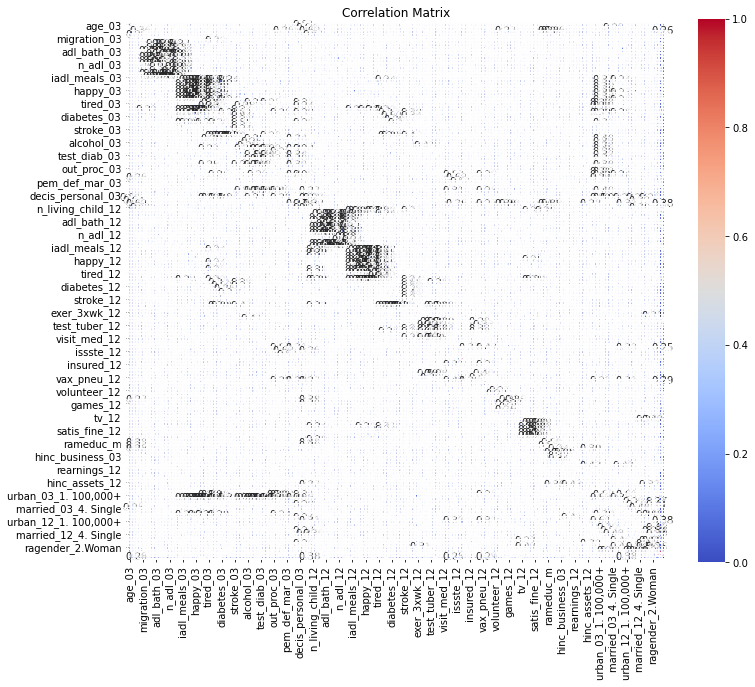

Dropped highly correlated features: []


In [260]:
corr_matrix = train_data.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
train_data = train_data.drop(high_corr, axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("Correlation Matrix")
plt.show()


In [263]:
corr_matrix = train_data.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = upper_tri.unstack().dropna()
filtered_corr_pairs = high_corr_pairs[high_corr_pairs > 0.6].sort_values(ascending=False)

print("High correlations (> 0.6) in descending order:")
print(filtered_corr_pairs.values)


High correlations (> 0.6) in descending order:
[0.78361047 0.75075154 0.74560942 0.73353067 0.72758643 0.72369651
 0.72032849 0.71523129 0.71472835 0.70726816 0.70212354 0.69747064
 0.69428256 0.68878324 0.67872095 0.66604177 0.65616239 0.65073632
 0.64994677 0.64417179 0.642634   0.63843653 0.63838864 0.63406405
 0.62547873 0.62500791 0.61933972 0.61802938 0.61190941 0.6077125
 0.60533971]


## 1 Temporal Change Features

Temporal changes over time in features such as health, ADL/IADL limitations, income, etc., can reveal patterns of decline.For each feature that has both a 2003 and 2012 version, we can calculate the difference to get an indication of change over time.

In [ ]:
# Change in Self-Reported Global Health
train_data['glob_hlth_change'] = train_data['glob_hlth_12'].astype(float) - train_data['glob_hlth_03'].astype(float)

# Change in ADL/IADL Limitations
train_data['adl_change'] = train_data['n_adl_12'].astype(float) - train_data['n_adl_03'].astype(float)
train_data['iadl_change'] = train_data['n_iadl_12'].astype(float) - train_data['n_iadl_03'].astype(float)

# Change in Marital Status
train_data['marital_change'] = (train_data['married_12'] != train_data['married_03']).astype(int)

# Change in Employment Status
train_data['employment_change'] = (train_data['employment_12'] != train_data['employment_03']).astype(int)

# Change in Depression Symptoms
train_data['depression_change'] = train_data['n_depr_12'].astype(float) - train_data['n_depr_03'].astype(float)

# Change in Income Levels
train_data['income_change'] = train_data['hincome_12'].astype(float) - train_data['hincome_03'].astype(float)

## 2 Aggregate Health Indicators

These features sum up related aspects to give a broader view of health, physical limitations, or mental health status.

In [ ]:
# Cumulative Health Issues Score
train_data['total_health_issues'] = train_data['n_illnesses_12'].fillna(0) + train_data['n_illnesses_03'].fillna(0)

# Physical Limitation Composite Score
train_data['physical_limitation_score'] = train_data[['adl_dress_12', 'adl_walk_12', 'adl_bath_12', 
                                                      'adl_eat_12', 'adl_bed_12', 'adl_toilet_12']].sum(axis=1)

# Mental Health Composite Score
mental_health_columns = ['depressed_12', 'hard_12', 'restless_12', 'happy_12', 'lonely_12', 
                         'enjoy_12', 'sad_12', 'tired_12', 'energetic_12']
train_data['mental_health_score'] = train_data[mental_health_columns].sum(axis=1)

# Cognitive Activity Engagement Score
cognitive_activity_columns = ['reads_12', 'games_12', 'table_games_12', 'attends_class_12', 
                              'comms_tel_comp_12', 'attends_club_12']
train_data['cognitive_activity_score'] = train_data[cognitive_activity_columns].sum(axis=1)

# Social Support Composite Score
social_support_columns = ['rrfcntx_m_12', 'rsocact_m_12', 'rrelgwk_12']
train_data['social_support_score'] = train_data[social_support_columns].apply(pd.to_numeric, errors='coerce').sum(axis=1)

## 3. Interaction Features

These interaction features can reveal if certain conditions or combinations are associated with higher cognitive decline.Interaction features can help capture the combined effects of health, economic status, and demographic factors.

In [ ]:
# Health and Economic Interaction
train_data['health_education_interaction'] = train_data['n_illnesses_12'].fillna(0) * train_data['edu_gru_12'].astype(float)

# Physical Limitations and Age
train_data['physical_age_interaction'] = train_data['age_12'].astype(float) * train_data['n_adl_12'].fillna(0)

# Migration and Economic Status
train_data['migration_income_interaction'] = train_data['migration_12'].astype(float) * train_data['hincome_12'].astype(float)

# Health Insurance and Health Status
train_data['insurance_health_interaction'] = train_data['insured_12'].astype(float) * train_data['n_illnesses_12'].fillna(0)


## 4. Derived Indicators

These indicators focus on flagging specific conditions, such as early retirement or changes in physical abilities.

In [ ]:
# Early Retirement Indicator
train_data['early_retirement'] = ((train_data['rjob_end_03'] < 60) | (train_data['rjob_end_12'] < 60)).astype(int)

# ADL/IADL Change Flag
train_data['adl_iadl_increase'] = ((train_data['adl_change'] > 0) | (train_data['iadl_change'] > 0)).astype(int)

# Loneliness/Depression Duration
depressive_columns = ['lonely_03', 'sad_03', 'depressed_03', 'lonely_12', 'sad_12', 'depressed_12']
train_data['depression_duration'] = train_data[depressive_columns].sum(axis=1) / len(depressive_columns)


## 5. Stability and Lifestyle Consistency

Indicators of consistency in lifestyle or relationships might impact long-term cognitive resilience.

In [ ]:
# Marital Stability Indicator
train_data['marital_stability'] = ((train_data['married_12'] == train_data['married_03']) & (train_data['married_03'] != 'NaN')).astype(int)

# Consistency in Employment Status
train_data['employment_stability'] = ((train_data['employment_12'] == train_data['employment_03']) & (train_data['employment_03'] != 'NaN')).astype(int)

# Lifestyle Stability Index
lifestyle_features = ['tobacco_12', 'alcohol_12', 'exer_3xwk_12']
train_data['lifestyle_stability'] = train_data[lifestyle_features].sum(axis=1) / len(lifestyle_features)


In [ ]:
# Identify columns by data type
num_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_features = data.select_dtypes(include=['object']).columns.tolist()

# Imputation Strategies
numeric_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

knn_imputer = KNNImputer(n_neighbors=5)

# Select columns with high missing values for KNN imputation
high_missing_cols = [col for col in num_features if data[col].isnull().mean() > 0.4]


In [177]:
# Print all column names as a list
print(list(train_data.columns))



['uid', 'age_03', 'urban_03', 'married_03', 'n_mar_03', 'edu_gru_03', 'n_living_child_03', 'migration_03', 'glob_hlth_03', 'adl_dress_03', 'adl_walk_03', 'adl_bath_03', 'adl_eat_03', 'adl_bed_03', 'adl_toilet_03', 'n_adl_03', 'iadl_money_03', 'iadl_meds_03', 'iadl_shop_03', 'iadl_meals_03', 'n_iadl_03', 'depressed_03', 'hard_03', 'restless_03', 'happy_03', 'lonely_03', 'enjoy_03', 'sad_03', 'tired_03', 'energetic_03', 'n_depr_03', 'cesd_depressed_03', 'hypertension_03', 'diabetes_03', 'resp_ill_03', 'arthritis_03', 'hrt_attack_03', 'stroke_03', 'cancer_03', 'n_illnesses_03', 'exer_3xwk_03', 'alcohol_03', 'tobacco_03', 'test_chol_03', 'test_tuber_03', 'test_diab_03', 'test_pres_03', 'hosp_03', 'visit_med_03', 'out_proc_03', 'visit_dental_03', 'imss_03', 'issste_03', 'pem_def_mar_03', 'insur_private_03', 'insur_other_03', 'insured_03', 'decis_personal_03', 'employment_03', 'age_12', 'urban_12', 'married_12', 'n_mar_12', 'edu_gru_12', 'n_living_child_12', 'migration_12', 'glob_hlth_12', '

In [179]:
categorical_columns = train_data.select_dtypes(include=['object']).columns.tolist()
numerical_columns = train_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [178]:
# Group features by their data types
grouped_features = {
    'numeric': train_data.select_dtypes(include=['int64', 'float64']).columns.tolist(),
    'categorical': train_data.select_dtypes(include=['object', 'category']).columns.tolist(),
    'boolean': train_data.select_dtypes(include=['bool']).columns.tolist(),
    'datetime': train_data.select_dtypes(include=['datetime64']).columns.tolist()
}

# Display the grouped features
for dtype, features in grouped_features.items():
    print(f"{dtype.capitalize()} Features: {features}")


Numeric Features: ['age_03', 'urban_03', 'married_03', 'n_mar_03', 'edu_gru_03', 'n_living_child_03', 'migration_03', 'glob_hlth_03', 'adl_dress_03', 'adl_walk_03', 'adl_bath_03', 'adl_eat_03', 'adl_bed_03', 'adl_toilet_03', 'n_adl_03', 'iadl_money_03', 'iadl_meds_03', 'iadl_shop_03', 'iadl_meals_03', 'n_iadl_03', 'depressed_03', 'hard_03', 'restless_03', 'happy_03', 'lonely_03', 'enjoy_03', 'sad_03', 'tired_03', 'energetic_03', 'n_depr_03', 'cesd_depressed_03', 'hypertension_03', 'diabetes_03', 'resp_ill_03', 'arthritis_03', 'hrt_attack_03', 'stroke_03', 'cancer_03', 'n_illnesses_03', 'exer_3xwk_03', 'alcohol_03', 'tobacco_03', 'test_chol_03', 'test_tuber_03', 'test_diab_03', 'test_pres_03', 'hosp_03', 'visit_med_03', 'out_proc_03', 'visit_dental_03', 'imss_03', 'issste_03', 'pem_def_mar_03', 'insur_private_03', 'insur_other_03', 'insured_03', 'decis_personal_03', 'employment_03', 'age_12', 'urban_12', 'married_12', 'n_mar_12', 'edu_gru_12', 'n_living_child_12', 'migration_12', 'glob_

In [111]:
# Grouping the features based on their types
numerical_features = [
    'age_03', 'age_12', 'rearnings_03', 'hincome_03', 'hinc_business_03', 
    'hinc_rent_03', 'hinc_assets_03', 'hinc_cap_03', 'rinc_pension_03',
    'rearnings_12', 'searnings_12', 'hincome_12', 'hinc_business_12', 
    'hinc_rent_12', 'hinc_assets_12', 'hinc_cap_12', 'rinc_pension_12', 
    'sinc_pension_12', 'n_mar_03', 'n_living_child_03', 'n_mar_12', 
    'n_living_child_12', 'glob_hlth_03', 'glob_hlth_12', 'bmi_12',
    'visit_med_03', 'visit_med_12', 'test_chol_03', 'test_chol_12',
    'test_tuber_03', 'test_tuber_12', 'test_diab_03', 'test_diab_12', 
    'test_pres_03', 'test_pres_12'
]

ordinal_features = [
    'glob_hlth_03', 'adl_dress_03', 'adl_walk_03', 'adl_bath_03', 
    'adl_eat_03', 'adl_bed_03', 'adl_toilet_03', 'n_adl_03', 'iadl_money_03', 
    'iadl_meds_03', 'iadl_shop_03', 'iadl_meals_03', 'n_iadl_03', 
    'n_depr_03', 'depressed_03', 'happy_03', 'lonely_03', 'enjoy_03', 
    'sad_03', 'tired_03', 'energetic_03', 'cesd_depressed_03',
    'glob_hlth_12', 'adl_dress_12', 'adl_walk_12', 'adl_bath_12', 
    'adl_eat_12', 'adl_bed_12', 'adl_toilet_12', 'n_adl_12', 'iadl_money_12', 
    'iadl_meds_12', 'iadl_shop_12', 'iadl_meals_12', 'n_iadl_12', 
    'n_depr_12', 'depressed_12', 'happy_12', 'lonely_12', 'enjoy_12', 
    'sad_12', 'tired_12', 'energetic_12', 'cesd_depressed_12'
]

nominal_features = [
    'hypertension_03', 'diabetes_03', 'arthritis_03', 'hrt_attack_03', 
    'stroke_03', 'cancer_03', 'exer_3xwk_03', 'alcohol_03', 'tobacco_03', 
    'hosp_03', 'imss_03', 'issste_03', 'insur_private_03', 'insur_other_03', 
    'insured_03', 'employment_03', 'hypertension_12', 'diabetes_12', 
    'arthritis_12', 'hrt_attack_12', 'stroke_12', 'cancer_12', 'exer_3xwk_12', 
    'alcohol_12', 'tobacco_12', 'hosp_12', 'imss_12', 'issste_12', 
    'insur_private_12', 'insur_other_12', 'insured_12', 'employment_12', 
    'volunteer_12', 'attends_class_12', 'attends_club_12', 'reads_12', 
    'games_12', 'tv_12'
]

demographic_features = [
    'ragender', 'sgender_12', 'rameduc_m', 'rafeduc_m', 'rrelgimp_03', 'rrelgimp_12'
]

In [113]:
train_data_cleaned.head()

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,hinc_assets_12,hinc_cap_12,rinc_pension_12,sinc_pension_12,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,1.134113,NaN,NaN,NaN,4. Fair,0.0,...,0.0,10000.0,0.0,0.00000,2.somewhat important,9.Never,9.Never,0.No,NaN,Concrete 2
1,aanz,NaN,NaN,NaN,1.134113,NaN,NaN,NaN,4. Fair,0.0,...,0.0,0.0,0.0,0.00000,1.very important,9.Never,1.Almost every day,0.No,NaN,Concrete 2
2,aape,NaN,NaN,NaN,1.134113,NaN,NaN,NaN,4. Fair,0.0,...,0.0,0.0,0.0,0.00000,2.somewhat important,6.2 or 3 times a month,2.4 or more times a week,0.No,NaN,"Wood, mosaic, or other covering 1"
3,aard,1. 50–59,"1. 100,000+",3. Widowed,1.000000,3. 7–9 years,1. 1 or 2,0.0,4. Fair,0.0,...,0.0,0.0,0.0,11936.87231,1.very important,4.Once a week,9.Never,1.Yes,No 2,Concrete 2
4,ablr,NaN,NaN,NaN,1.134113,NaN,NaN,NaN,4. Fair,0.0,...,0.0,0.0,0.0,0.00000,1.very important,3.2 or 3 times a week,3.2 or 3 times a week,0.No,NaN,"Wood, mosaic, or other covering 1"


In [114]:
# Function to separate numeric part from string-encoded categorical values
def clean_encoded_strings(train_data_cleaned, columns):
    for col in columns:
        if col in train_data_cleaned.columns:  # Check if column exists
            # Extract numeric part only (if it exists)
            train_data_cleaned[col] = train_data_cleaned[col].astype(str).fillna('').str.extract('(\d+)').astype(float)
    return train_data_cleaned

# List of columns that need cleaning for encoded values
encoded_columns = [
    'married_03', 'edu_gru_03', 'n_living_child_03', 'glob_hlth_03', 'bmi_03', 'decis_famil_03', 
    'employment_03', 'age_12', 'urban_12', 'married_12', 'edu_gru_12', 'n_living_child_12', 
    'glob_hlth_12', 'bmi_12', 'decis_famil_12', 'decis_personal_12', 'employment_12', 
    'satis_ideal_12', 'satis_excel_12', 'satis_fine_12', 'cosas_imp_12', 'wouldnt_change_12', 
    'memory_12', 'ragender', 'rameduc_m', 'rafeduc_m', 'sgender_03', 'rjlocc_m_03', 
    'rjobend_reason_03', 'rrelgimp_03', 'sgender_12', 'rjlocc_m_12', 'rjobend_reason_12', 
    'rrelgimp_12', 'rrfcntx_m_12', 'rsocact_m_12', 'rrelgwk_12', 'a34_12', 'j11_12'
]

# Clean the encoded columns
train_data_cleaned = clean_encoded_strings(train_data_cleaned, encoded_columns)



In [115]:
train_data_cleaned.shape

(3276, 167)

In [116]:
train_data_cleaned.head()

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,hinc_assets_12,hinc_cap_12,rinc_pension_12,sinc_pension_12,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,1.134113,NaN,NaN,NaN,4.0,0.0,...,0.0,10000.0,0.0,0.00000,2.0,9.0,9.0,0.0,NaN,2.0
1,aanz,NaN,NaN,NaN,1.134113,NaN,NaN,NaN,4.0,0.0,...,0.0,0.0,0.0,0.00000,1.0,9.0,1.0,0.0,NaN,2.0
2,aape,NaN,NaN,NaN,1.134113,NaN,NaN,NaN,4.0,0.0,...,0.0,0.0,0.0,0.00000,2.0,6.0,2.0,0.0,NaN,1.0
3,aard,1. 50–59,"1. 100,000+",3.0,1.000000,3.0,1.0,0.0,4.0,0.0,...,0.0,0.0,0.0,11936.87231,1.0,4.0,9.0,1.0,2.0,2.0
4,ablr,NaN,NaN,NaN,1.134113,NaN,NaN,NaN,4.0,0.0,...,0.0,0.0,0.0,0.00000,1.0,3.0,3.0,0.0,NaN,1.0


In [126]:


missing_values = train_data_cleaned.isnull().sum()


missing_values_df = pd.DataFrame(missing_values, columns=['Missing Count']).reset_index()
missing_values_df.columns = ['Column Name', 'Missing Count']


non_zero_missing_df = missing_values_df[missing_values_df['Missing Count'] > 0]


non_zero_missing_df = non_zero_missing_df.sort_values(by='Missing Count', ascending=False)


print(non_zero_missing_df)


           Column Name  Missing Count
116     decis_famil_12           1226
57   decis_personal_03           1178
23         restless_03           1172
22             hard_03           1172
165             a34_12           1164
6    n_living_child_03           1046
5           edu_gru_03           1044
1               age_03           1036
7         migration_03           1035
39      n_illnesses_03           1035
34         resp_ill_03           1034
3           married_03           1034
2             urban_03           1034
53      pem_def_mar_03           1034
50     visit_dental_03           1034
49         out_proc_03           1034
98              bmi_12            438
120        vax_pneu_12            291
134     satis_ideal_12            277
138  wouldnt_change_12            248
139          memory_12            245
135     satis_excel_12            239
137       cosas_imp_12            228
162       rrfcntx_m_12            225
117  decis_personal_12            225
119         

In [130]:

# 1. Categorical Columns: Fill missing values with the mode (most frequent value)
# Explanation: For categorical data, the most frequent value often makes a reasonable assumption for the missing value.
categorical_columns = [
    'age_03', 'edu_gru_03', 'married_03', 'urban_03'
]

for col in categorical_columns:
    # Check if mode exists and handle the case where mode is empty
    mode_value = train_data_cleaned[col].mode()
    if not mode_value.empty:
        train_data_cleaned[col].fillna(mode_value[0], inplace=True)
    else:
        print(f"Warning: Column {col} has no mode (empty column).")

# 2. Binary Columns: Fill missing values with the most frequent value in the column
# Explanation: Since binary columns typically have two values, using the most common (e.g., 0 or 1) aligns with the prevailing trend.
binary_columns = [
    'migration_03', 'pem_def_mar_03', 'resp_ill_03', 'hard_03'
]

for col in binary_columns:
    most_frequent = train_data_cleaned[col].value_counts().idxmax() if not train_data_cleaned[col].value_counts().empty else None
    if most_frequent is not None:
        train_data_cleaned[col].fillna(most_frequent, inplace=True)
    else:
        print(f"Warning: Column {col} has no values to determine most frequent.")

# 3. Numerical Columns: Fill missing values with the median
# Explanation: For numerical columns, the median is a robust measure, especially if the data is skewed.
numerical_columns = [
    'n_living_child_03', 'n_illnesses_03', 'vax_pneu_12'
]

for col in numerical_columns:
    if train_data_cleaned[col].notna().sum() > 0:
        train_data_cleaned[col].fillna(train_data_cleaned[col].median(), inplace=True)
    else:
        print(f"Warning: Column {col} has no numeric values for median calculation.")

# 4. Year-Based Feature Engineering: Interpolate missing values between 2003 and 2012 for paired columns
# Explanation: For columns where data is available across multiple years, filling missing values in one year
# by referencing the other year’s value can provide a reasonable estimate, assuming stability over time.
paired_columns = [
    ('resp_ill_03', 'resp_ill_12')
]

for col_03, col_12 in paired_columns:
    train_data_cleaned[col_03].fillna(train_data_cleaned[col_12], inplace=True)
    train_data_cleaned[col_12].fillna(train_data_cleaned[col_03], inplace=True)

# 5. New Feature Creation for Missing Indicators: Add binary columns to indicate missing data
# Explanation: Adding binary "missing" indicators helps capture missingness as a feature, which can
# contribute useful signals during analysis or modeling.
missing_indicators = [
    'depressed_03', 'decis_famil_12'
]

for col in missing_indicators:
    train_data_cleaned[f'{col}_missing'] = train_data_cleaned[col].isnull().astype(int)


In [131]:
train_data_cleaned.isnull().sum()

uid                          0
age_03                       0
urban_03                     0
married_03                   0
n_mar_03                     0
                          ... 
rrelgwk_12                 218
a34_12                    1164
j11_12                      75
depressed_03_missing         0
decis_famil_12_missing       0
Length: 169, dtype: int64

In [133]:
missing_values_after = train_data_cleaned.isnull().sum()


missing_values_after_df = pd.DataFrame(missing_values_after, columns=['Missing Count']).reset_index()
missing_values_after_df.columns = ['Column Name', 'Missing Count']


non_zero_missing_after_df = missing_values_after_df[missing_values_after_df['Missing Count'] > 0]


non_zero_missing_after_df = non_zero_missing_after_df.sort_values(by='Missing Count', ascending=False)

print(non_zero_missing_after_df)


           Column Name  Missing Count
116     decis_famil_12           1226
57   decis_personal_03           1178
23         restless_03           1172
165             a34_12           1164
50     visit_dental_03           1034
49         out_proc_03           1034
98              bmi_12            438
134     satis_ideal_12            277
138  wouldnt_change_12            248
139          memory_12            245
135     satis_excel_12            239
137       cosas_imp_12            228
162       rrfcntx_m_12            225
117  decis_personal_12            225
136      satis_fine_12            223
119         vax_flu_12            223
81         restless_12            219
129     table_games_12            219
164         rrelgwk_12            218
80             hard_12            218
130  comms_tel_comp_12            218
123      care_child_12            217
122      care_adult_12            216
131        act_mant_12            216
133          sewing_12            216
163       rs

In [118]:
duplicate_rows = data.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)


Number of duplicate rows: 0
